**Milestone 2 Phase 2**

---


Rahmad Gunawan
FTDS-Batch 013

URL Deploy : https://dashboard.heroku.com/apps/fe-fire-predection-ragun

![Say Haii](https://img.freepik.com/free-photo/fire-flames-black-background_158595-4100.jpg?w=1380&t=st=1661053554~exp=1661054154~hmac=04da55524c060995bb1db516a8fd02a425a75964d1b4872f78262ddc7d96e930&w=500&h=500))

Sumber gambar : [freepik.com](https://img.freepik.com/free-photo/fire-flames-black-background_158595-4100.jpg?w=1380&t=st=1661053554~exp=1661054154~hmac=04da55524c060995bb1db516a8fd02a425a75964d1b4872f78262ddc7d96e930)


# **I.Perkenalan**

Milestones 2 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :.

**Deskripsi :** 
Dataset yang digunakan pada project ini adalah dataset yang berisi informasi tentang *Fire Dataset* yaitu Kumpulan data yang terdiri atas gambar kebakaran (mengandung api) dan non kebakakaran (gambar non-api), Dataset ini digunakan dengan tujuan untuk membuat model yang dapat mengenali gambar yang terdapat unsur api.
pada dataset ini data dibagi menjadi 2 folder, folder fireimages berisi 755 gambar kebakaran luar ruangan beberapa di antaranya berisi asap tebal, yang lainnya adalah gambar non-api yang berisi 244 gambar alam (misalnya: hutan, pohon, rumput, sungai, orang, hutan berkabut, danau, binatang, jalan, dan air terjun).

**Objektif :**
Milestones 2 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :
1. Mampu memahami konsep Computer Vision/NLP.
2. Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP
3. Mampu mengimplementasikan Artificial Neural Network dengan data yang ada
4. Mampu menganalisis dan menjelaskan layer yang dibuat.

**Objektif pada kasus ini adalah, dapat membuat model yang dapat memprediksi gambar yang terdapat unsur api dan non api**


# **II. Import Libraries**

**Library yang digunakan adalah Numpy, Pandas, Sklearn, Scipy, Plotly dan Tensor Flow**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import os
import requests
import tensorflow as tf
import random
import pathlib
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import Recall,AUC
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from PIL import Image
from io import BytesIO

# **III. Data Loading**

Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading ini dimulai dengan mensetting direktori untuk membuat folder dataset, yang nantinya folder tersebut akan digunakan sebagai tempat untuk mengunduh dataset yang berasal dari kaggle

In [2]:
!mkdir -p ~/.kaggle #membuat folder pada kaggle root
!cp kaggle.json ~/.kaggle # mengcopy paste kaggle.json ke folder kaggle 

!mkdir ./kaggle #membuat folder kaggle di lokasi sama, namun bukan di root
!mv ./kaggle.json ./kaggle # memindahkan file kaggle.json ke folder kaggle yang sudah dibuat

cp: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘./kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory


In [3]:
!chmod 600 ~/.kaggle/kaggle.json # perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle # untuk mengechek list data yang ada di folder kaggle

kaggle.json


In [4]:
!kaggle datasets download -d phylake1337/fire-dataset # download dataset yang bersumber dari kaggle

fire-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -q /content/fire-dataset.zip # mengekstrak hasil download-an dalam format zip ke dalam bentuk folder

replace fire_dataset/fire_images/fire.1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# **IV. *Exploratory Data Analysis (EDA)***

Tahapan ini dilakukan untuk mengenal lebih dalam terkait masing-masing *dataset* serta untuk dapat memberikan gambaran dasar secara umum isi dalam dataset tersebut. 

## **A. *EDA Jumlah pada Dataset***

In [6]:
os.listdir('/content/fire_dataset') # tahapan untuk men-check isi dalam dataset

['assets',
 'variables',
 'fire_images',
 'keras_metadata.pb',
 'non_fire_images',
 'saved_model.pb']

dalam dataset tersebut terdapat 2 folder yaitu fire_images dan non_fire_images, folder fire_images merupakan kumpulan gambar yang berisikan gambar yang memiliki unsur api didalamnya, dan pada folder non_fire_images, merupakan berisikan gambar yang tidak memiliki unsur api, seperti gambar hutan lebat, air, dll

In [7]:
dataset = '/content/fire_dataset' # memasukan direktori fire dataset ke dalam function dataset

In [8]:
# Tahapan untuk melihat pada masing-masing folder, jumlah gambar fire/non fire
for dirpath, dirnames, filenames in os.walk(dataset): 
  print(f'Found {len(dirnames)} folders with {len(filenames)} images in {dirpath}')

Found 4 folders with 2 images in /content/fire_dataset
Found 0 folders with 0 images in /content/fire_dataset/assets
Found 0 folders with 2 images in /content/fire_dataset/variables
Found 0 folders with 755 images in /content/fire_dataset/fire_images
Found 0 folders with 244 images in /content/fire_dataset/non_fire_images


Berdasarkan informasi diatas, kita dapat melihat bahwa pada folder fire images terdapat 755 data yang berisikan gambar yang mengandung unsur api, dan pada folder non fire images terdapat 244 gambar

**Berdasarkan informasi tersebut kita dapat melihat bahwa, dataset antara fire images dan non fire images , imbalanced (tidak berimbang), dikarenakan jumlah gambar pada fire lebih banyak dibandingkan non fire, hal tersebut tentunya akan berakibat pada pembentukan model, dimana nantinya model yang terbentuk cenderung akan bias terhadap data yang jumlahnya lebih besar, atau dalam kasus ini adalah gambar fire, dimana nantinya terdapat potensi kegagalan model dalam memprediksi gambar non fire, oleh karena itu pada pemilihan metriks kasus ini, kita perlu menekankan pada metriks recall, adapun langkah lainnya untuk mengatasi permasalahan tersebut adalah akan disiapkan data yang sudah melalui proses augmentasi, untuk kemudian dibandingkan hasilnya dengan data yang murni**.

In [9]:
df = pd.DataFrame(columns=['path','label']) # membuat dataframe baru

# membuat gambar yang mengandung unsur api kedalam 
# kita akan menggunakan loop untuk mempermudah dalam pembagian kelas tersebut
for dirname, _, filenames in os.walk('/content/fire_dataset/fire_images'): #direktori dataset yang mengandung api
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])) # memasukan dataset images yang mengandung api tersebut kedalam dataframe

# membuat gambar yang tidak mengandung unsur api kedalam 
for dirname, _, filenames in os.walk('/content/fire_dataset/non_fire_images'): #direktori dataset yang tidak mengandung api 
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
    
df = df.sample(frac=1).reset_index(drop=True) 
df.head(10) # menampilkan hasil pembuatan dataframe

path     label
0  /content/fire_dataset/non_fire_images/non_fire...  non_fire
1     /content/fire_dataset/fire_images/fire.325.png      fire
2     /content/fire_dataset/fire_images/fire.717.png      fire
3  /content/fire_dataset/non_fire_images/non_fire...  non_fire
4     /content/fire_dataset/fire_images/fire.735.png      fire
5     /content/fire_dataset/fire_images/fire.598.png      fire
6  /content/fire_dataset/non_fire_images/non_fire...  non_fire
7     /content/fire_dataset/fire_images/fire.225.png      fire
8     /content/fire_dataset/fire_images/fire.228.png      fire
9  /content/fire_dataset/non_fire_images/non_fire...  non_fire

In [10]:
df.duplicated().sum() # mengecek apakah terdapat duplikasi pada dataset yang diload

0

Data dikumpulkan untuk melatih model untuk membedakan antara gambar yang mengandung api (gambar api) dan gambar biasa (gambar non-api), dan target klasifikasi binary

Data dibagi menjadi 2 folder, folder gambar api berisi 755 gambar kebakaran beberapa di antaranya berisi asap tebal, yang lainnya adalah gambar non-api yang berisi 244 gambar alam (misalnya: hutan, pohon, rumput, sungai, orang, berkabut hutan, danau, binatang, jalan, dan air terjun).

## **B. *Visualisasi Dataset***

In [11]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])
fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['red','blue'],showlegend=False),row=1,col=1)
fig.add_trace(go.Pie(values=df['label'].value_counts().to_numpy(),labels=df['label'].value_counts().index,marker=dict(colors=['red','blue'])),row=1, col=2)

Berdasarkan hasil visualisasi diatas, kita dapat melihat bahwa data pada dataset tersebut imbalanced, dimana gambar fire lebih mendominasi dibandingkan gambar non fire, tahapan selanjutnya adalah kita dapat melihat isi/visualisasi dari setiap folder, baik folder fire ataupun folder non fire

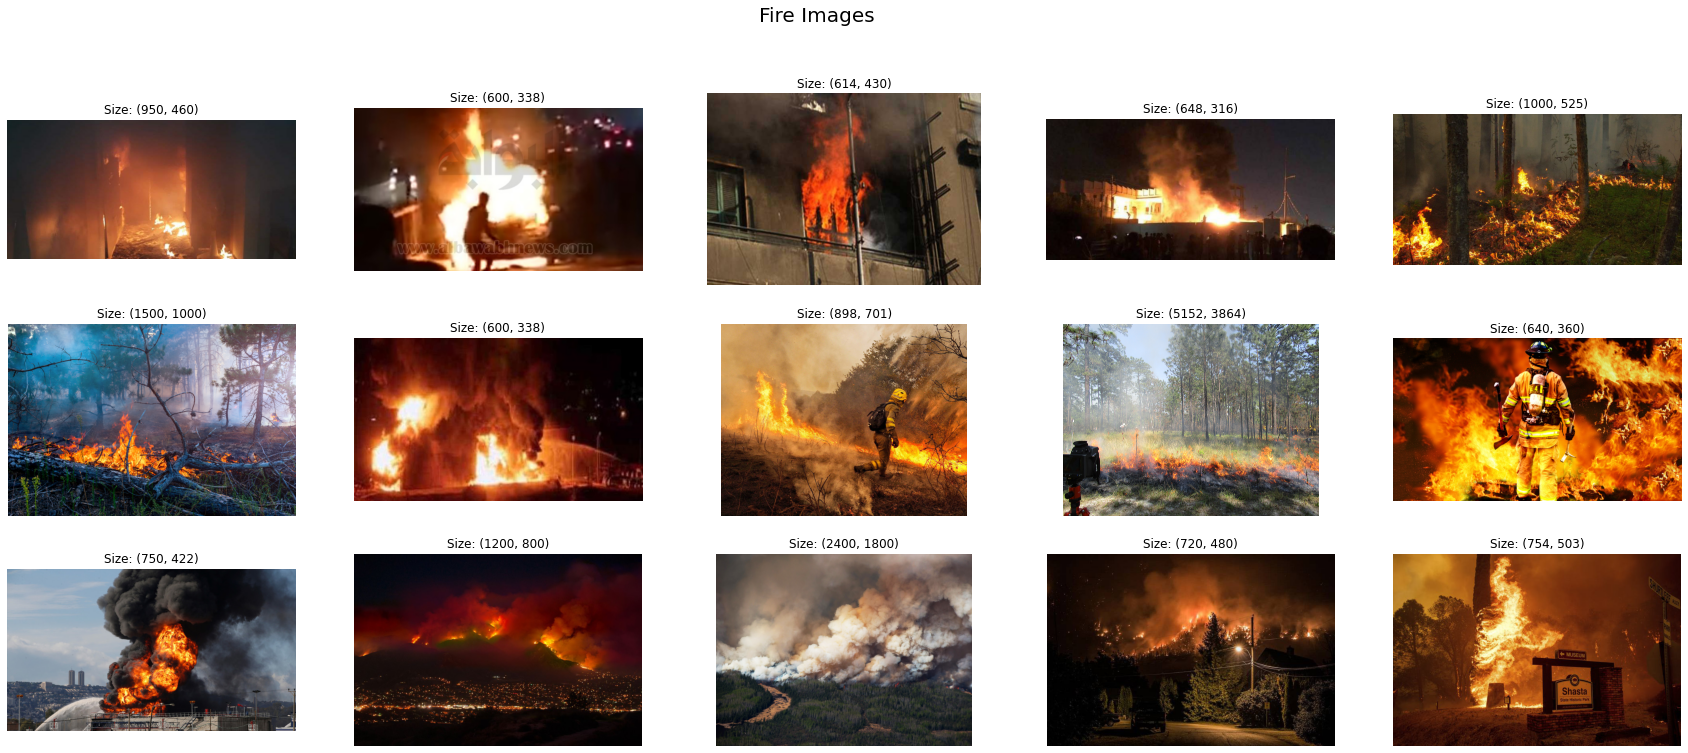

In [12]:
plt.figure(figsize=(30, 12))
plt.suptitle('Fire Images', fontsize=20)
for i in range(15):
    plt.subplot(3, 5, i+1)
    random_img = random.sample(os.listdir(dataset + '/fire_images/'), 1)
    img = image.load_img(dataset + '/fire_images/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

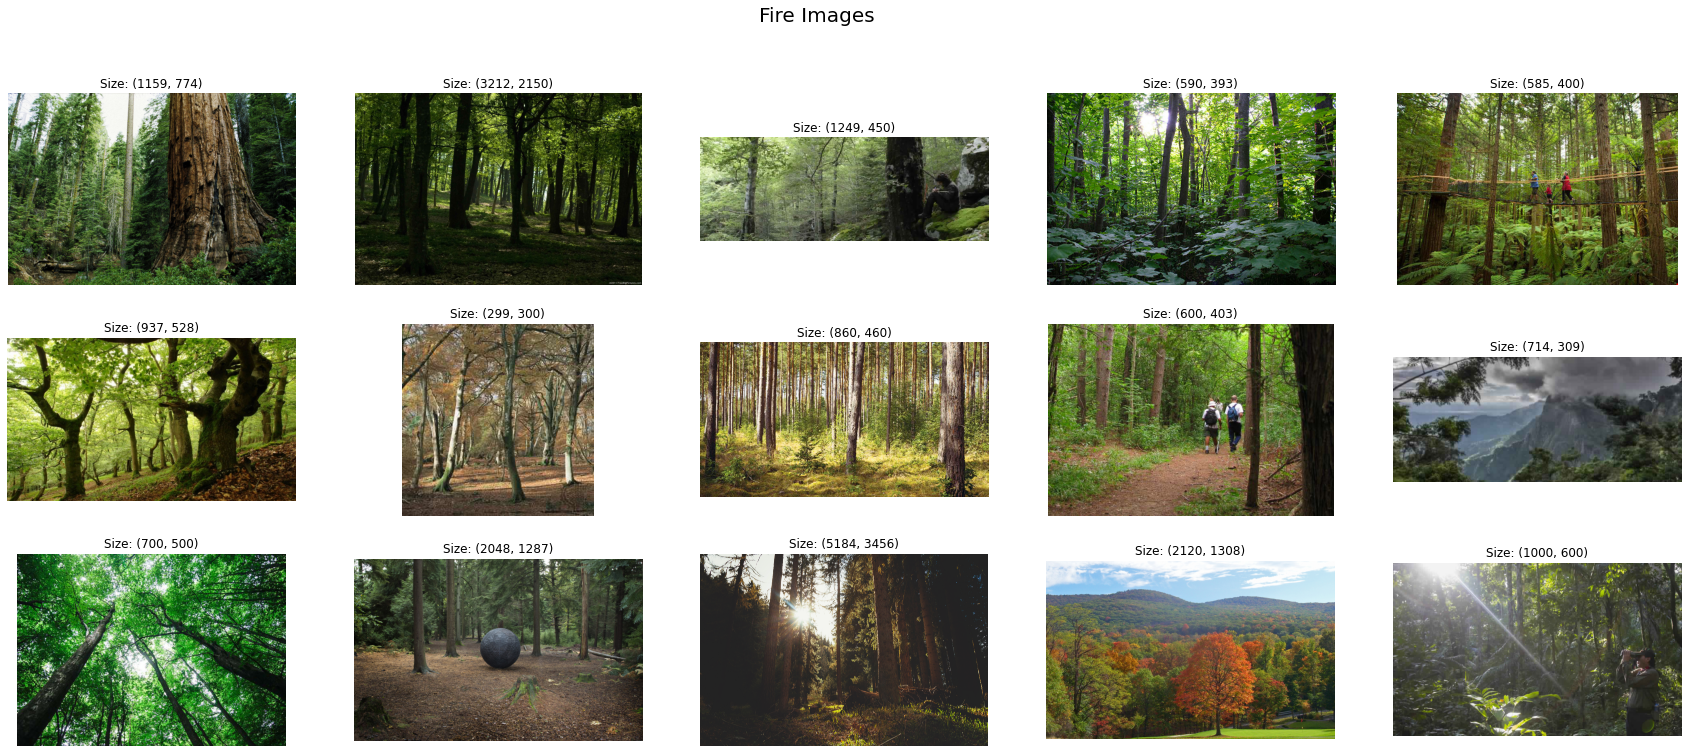

In [13]:
plt.figure(figsize=(30, 12))
plt.suptitle('Fire Images', fontsize=20)
for i in range(15):
    plt.subplot(3, 5, i+1)
    random_img = random.sample(os.listdir(dataset + '/non_fire_images/'), 1)
    img = image.load_img(dataset + '/non_fire_images/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Setelah membuat dataframe, langkah selanjutnya adalah memasukan informasi height dan widht ke dalam dataframe tersebut untuk mempermudah memberikan informasi setiap gambar pada dataset tersebut.

In [14]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(10)

path     label  height  width
0  /content/fire_dataset/non_fire_images/non_fire...  non_fire     435    653
1     /content/fire_dataset/fire_images/fire.325.png      fire     276    458
2     /content/fire_dataset/fire_images/fire.717.png      fire     990   1484
3  /content/fire_dataset/non_fire_images/non_fire...  non_fire     252    448
4     /content/fire_dataset/fire_images/fire.735.png      fire     404    647
5     /content/fire_dataset/fire_images/fire.598.png      fire    1266   1900
6  /content/fire_dataset/non_fire_images/non_fire...  non_fire     638    960
7     /content/fire_dataset/fire_images/fire.225.png      fire     555    740
8     /content/fire_dataset/fire_images/fire.228.png      fire     541   1000
9  /content/fire_dataset/non_fire_images/non_fire...  non_fire     628   1200

In [15]:
df.describe().T

count         mean         std    min    25%    50%     75%     max
height  999.0   737.782783  654.668709  147.0  394.5  534.0   750.5  4608.0
width   999.0  1152.563564  963.638092  185.0  640.0  860.0  1200.0  6720.0

Berdasarkan informasi diatas dapat kita lihat bahwa rata -rata gambar memiliki ukuran height 737 dan ukuran (lebar) weight yaitu 1152, namun dalam case ini untuk mempercepat proses komputasi, kita tidak akan membuat gambar pada dataset tersebut diubah mendekati ukuran rata-rata weight dan heightnya

# **V. *Data Preprocessing***

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi *data test, train dan validation*, dan proses-proses lain yang dibutuhkan.

## **A. *Data Splitting***

Membagi dataset menjadi data training, validation dan data testing

Pada tahapan ini seluruh dataset akan direscale untuk dimasakan ukuran height dan width dan juga setting beberapa parametera seperti zoom range, rotation range dll, adapun beberapa setting parameter sebagai berikut:
- `rescale` = 1/255
- `rotation_range` = 0.2
- `width_shift_range` = 0.1
- `height_shift_range` =  0.1
- `shear_range` = 0.2
- `zoom_range` = 0.2

In [16]:
df_split = df.copy() # tahapan membuat dataframe copy

# membagi data train, validation dan test
val_index = int(df_split.shape[0]*0.15) # nilai 0,15 merupakan nilai untuk pembagian data test atau 15% dari dataset
train_df = df_split.iloc[val_index:]
test_df = df_split.iloc[:val_index]

In [17]:
# menampilkan jumlah/shape pada data train
train_df.shape, test_df.shape

((850, 4), (149, 4))

Setelah membagi dataset tersebut menjadi data train dan data test, yaitu dengan pembagian data train sebanyak 850 dan data test 149, tahapan selanjutnya adalah membagi data train tersebut menjadi data validation dengan proporsi 15% dari total data train. Sedangkan untuk parameter trainnya, foto-foto akan diresize menjadi ukuran 256X256. Masing-masing batch terdiri dari 32 foto, pemilhan besaran batch tersebut disesuaikan dengan jumlah pada dataset yang tidak terlalu besar, nilai 32 dirasa sudah cukup pas untuk pada dataset ini. 
Class mode yang digunakan adalah binary karena hasil yang diharapkan hanya terbagi dalam dua kelas yaitu yes/fire atau no/no fire.

Tahapan selanjutnya adalah menampung gambar-gambar pada dataset ini yang telah dilakukan proses augmentasi. augmentasi dilakukan untuk untuk mendapatkan performa yang optimal, dimana seperti kita ketahui bahwa dalam Deep Learning membutuhkan data yang lebih banyak dibandingkan dengan machine learning biasa.

Dari dataset yang telah kita kumpulkan hanya terdapat 755 gambar api dan 244 gambar non api, atau berjumlah 999 gambar. Jumlah data tersebut masih kurang mencukupi untuk mendapatkan performa yang optimal. oleh karena itu kita perlu meng-augmentasi data tersebut. teknik augmentasi yang dilakukan dapat berupa rotate, flip, crop, dll

Untuk train, parameter shuffle dibiarkan True untuk mengacak sampel per epoch sehingga membuat model belajar lebih banyak tanpa melihat urutan sampel. Tetapi untuk selain train, diseeting shuflle False, untu memastikan output prediksi vs aktual dapat dibandingkan di akhir.

- **Rotation range** : menggunakan nilai yang kecil dikarenakan jika kita menggunakan nilai yang besar maka dapat merubah makna dari gambar tersebut atau bahkan membuat gambar tersebut menjadi aneh, contohnya jika kita merotate gambar tersebut dengan nilai 90 derajat maka terdapat object gambar yang berputar terbalik seperti pepohonan yang batangnya berada diatas dan daunnya dibawah, dan juga dapat terjadi pada gambar orang yang sedang memadamkan api, sehingga gambar orang tersebut menjadi berada diatas (kaki dan kepalnya berputar posisi) dan apinya berada dibawah.
- **widht shift** : menggunakan nilai 0.1 dikarenakan gambar diharapkan tidak terlalu bergeser secara acak , baik kekanan, ataupun kiri 
- **height shift** : sama seperti widht shift namun pada height perbedaanya adalah gambar diharapkan tidak bergeser secara acak dari atas ataupun bawah
- **zoom range**  : Zoom_range berfungsi untuk memperbesar gambar. Pada zoom_range
angka yang digunakan adalah 0.2 dikarenakan jika kita menggunakan nilai yang besar >0.5 maka dapat berpotensi object seperti api ataupun object lainnya akan hilang dikarenakan zoom nya terlalu besar. dalam kata lain tidak masuk kedalam frame
- **re-scale** : Fungsi rescale adalah untuk mengubah skala nilai gambar. Nilai 1/255 artinya setiap nilai akan dikali 1/255 sehingga nilainya akan berubah
menjadi antara 0 dan 1

In [18]:
# set random seed
tf.random.set_seed(17)

# preprocess data test
test_datagen = ImageDataGenerator(rescale=1/255.0) #Untuk project ini, baik test dan train set rescalenya adalah 1/255.0

# membuat variable untuk augmented object
train_datagen_augmented = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 0.2,
    zoom_range= 0.2,
    rescale = 1/255,
    validation_split=0.15, 
)


In [19]:
# Menggunakan object datagen
train_data = train_datagen_augmented.flow_from_dataframe(train_df,x_col='path',                      
                                                y_col='label',                                              
                                                images_size=(256,256),
                                                class_mode='binary',
                                                subset='training',
                                                seed = 15 )
valid_data = train_datagen_augmented.flow_from_dataframe(train_df,x_col='path',
                                                y_col='label',                                             
                                                images_size=(256,256)
                                                ,class_mode='binary',
                                                subset='validation',
                                                shuffle=False)
test_data= test_datagen.flow_from_dataframe(test_df,
                                             x_col='path',
                                             y_col='label',                                            
                                             images_size=(256,256),
                                             class_mode='binary',
                                             shuffle=False)

Found 723 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 149 validated image filenames belonging to 2 classes.


In [20]:
valid_data

In [21]:
valid_data.class_indices

{'fire': 0, 'non_fire': 1}


dapat dilihat bahwa class = 0 mengindikasikan bahwa dataset tersebut merupakan gambar api dan  1 adalah gambar tidak api, pada dataset ini juga memiliki 723 data train, 127 data validation dan 149 data test.

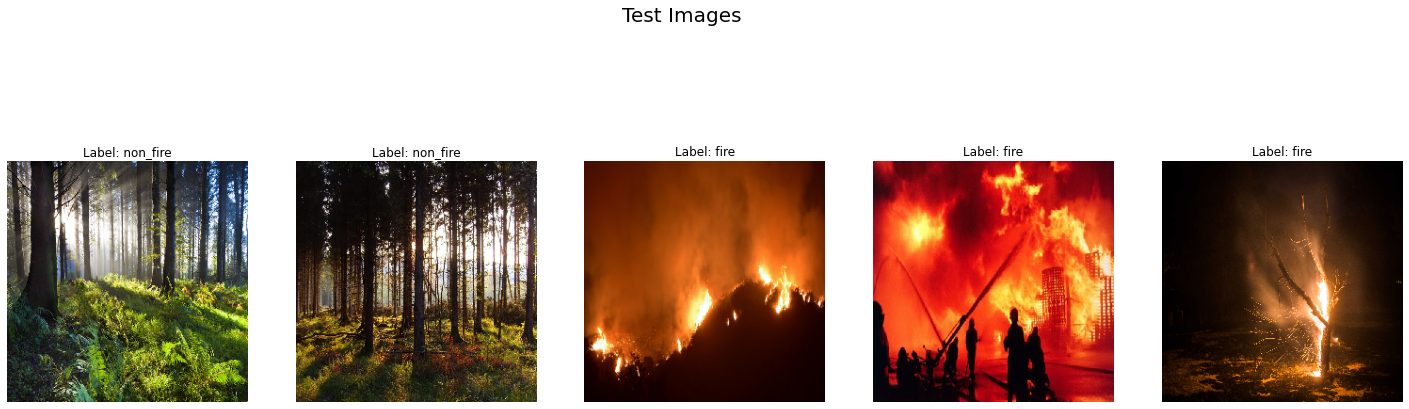

In [22]:
plt.figure(figsize=(25, 8))
plt.suptitle('Test Images', fontsize=20)
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_data[i][0][0])
    plt.title(f'Label: {"fire" if int(test_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

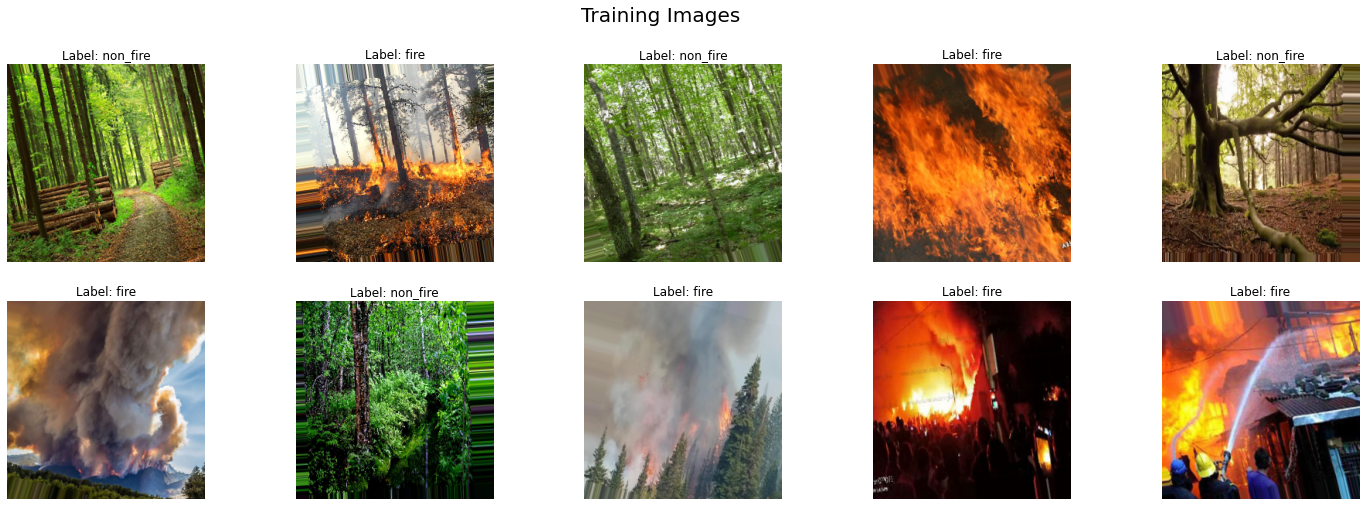

In [23]:
plt.figure(figsize=(25, 8))
plt.suptitle('Training Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Label: {"fire" if int(train_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

# **VI. *Model Definition***

Pada project kali ini akan dibuat satu model sequential. nantinya model tersebut akan dievaluasi untuk diimprove baik dengan meningkatkan waktu komputasi ataupun mencoba untuk meningkatkan performansi baik dari accuracy ataupun recall.

In [24]:
tf.keras.backend.clear_session()

## **Model Definition Base**

Arsitektur model ini adalah:
- Model dengan metode sequential.
- Input Shape (256, 256, 3), menunjukan bahwa semua ukuran gambar yang masuk ke dalam input layer berukuran 256×256 pixels, dan berukuran 3 array. Mengapa berukuran 3 array atau bukan 2 array? karena pada case ini gambar yang diload berwarna atau memiliki spectrum RGB (3) dan jika menggunakan gambar format hitam putih maka dapat menggunakan format 2 array.
- Untuk convolutional layernya digunakan Conv2D dengan 64 filter dan activationnya menggunakan relu. 
- parameter Convolution2D digunakan untuk memulai CNN di tahap awal yaitu proses convolution. mengapa menggunakan 2D, dikarenakan pada kasus ini kita akan mengolah data berupa gambar maka dimensi yang digunakan adalah 2D atau Convolution 2D
- filter=64. Artinya kita akan menggunakan 64 feature detectors yang berukuran 3×3 (kernel_size=(3,3)). 
- MaxPooling2D digunakan setelah proses convolution, yaitu dengan mengambil nilai maximumnya (disebut dengan maxpooling). Karena kita mengolah gambar, maka kita gunakan maxpooling untuk 2 dimensi.
- Flatten layer disini menggunakan parameter default.
- Fully connected layer dengan 16 neuron dengan activation relu. Input yang masuk kedalam neuron tidak hanya dikalikan dengan weightnya, akan tetapi mereka juga dikalikan dengan transfer function, semakin besar nilai neuron maka semakin lama waktu komputasinya, namun semakin besar neuron dapat meningkatkan performansi. 
- Output layer menggunakan activation sigmoid karena target labelnya merupakan binary class.


In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))) # 256 merupakan input size
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 16)                3

# **VII. *Model Training***

Setelah membuat model, tahapan selanjutnya adalah melatih model yang dibuat, model tersebut akan dilatih. Namun, sebelum model dilatih model akan dicompile terlebih dahulu. kita telah mengetahui bahwa pada kasus ini target dari model ini akan menghasilkan klasifikasi 2 kelas maka `loss` yang digunakan adalah **binary crossentropy**. 

Pada tahapan ini terdapat 1 model yang akan ditrain, nantinya akan dicoba diimprove dan kemudian akan dipilih salah satu model untuk disave dan dideploy.

**Pada Tahapan ini pemilihan metriks yang digunakan adalah metrik ROC, Recall, hal tersebut dikarenakan kita telah mengetahui bahwa pada kolom target distribusi datanya imbalanced gambar fire dan non fire**

In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()]) # model 1 disimpan dengan nama model

In [28]:
history_model= model.fit(train_data,epochs=25,batch_size=32, validation_data=valid_data, verbose =0)

# **VIII. *Model Evaluation***

Pada bagian ini, dilakukan evaluasi model dengan menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. disertakan visualisasi tren performa dan/atau tingkat kesalahan model, melakukan analisis terkait dengan hasil pada model dan menuliskan hasil analisis tersebut, untuk evaluasi yang akan dilakukan Metric evaluation yang akan digunakan adalah **Recall, ROC-AUC** score untuk memastikan bahwa model dapat memprediksi secara baik gambar dengan prioritas gambar yang tidak memiliki unsur api. 

## **A. Model Evaluation Model Base**

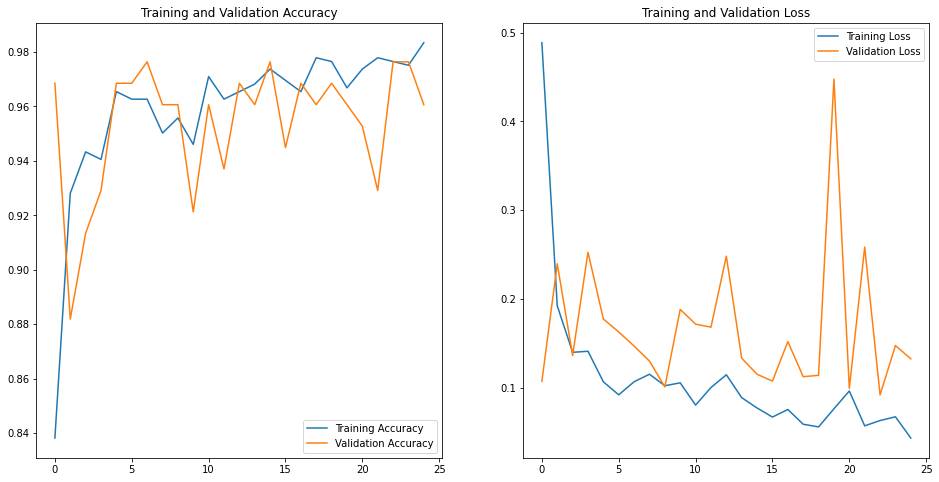

In [29]:
epochs=25
acc = history_model.history['accuracy']
loss = history_model.history['loss']

val_acc = history_model.history['val_accuracy']
val_loss = history_model.history['val_loss']
epoch_range = range(epochs)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
#print model evaluation
model.evaluate(test_data)

5/5 [==============================] - 4s 559ms/step - loss: 0.1618 - accuracy: 0.9396 - recall: 0.9756 - auc: 0.9907


[0.1617724895477295,
 0.9395973086357117,
 0.9756097793579102,
 0.9907406568527222]

In [31]:
#make train dataset unshuffled for predict
train_data_augmented_nonshuffled = train_datagen_augmented.flow_from_dataframe(train_df,x_col='path',                      
                                                y_col='label',
                                               batch_size=32,
                                               target_size=(256, 256),
                                               class_mode='binary',                                      
                                               subset='training',
                                               shuffle = False)

Found 723 validated image filenames belonging to 2 classes.


In [32]:
#do model prediction
y_train_pred = model.predict(train_data_augmented_nonshuffled)
y_test_pred = model.predict(test_data)

In [33]:
print('-----------Training Results-----------')
train_results = model.evaluate(train_data_augmented_nonshuffled, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Test Results-----------')
test_results = model.evaluate(test_data, verbose=0)
print(f'test Loss     : {test_results[0]:.4f}')
print(f'test Accuracy : {test_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.0419
Training Accuracy   : 0.9848
-----------Test Results-----------
test Loss     : 0.1618
test Accuracy : 0.9396


In [34]:
y_pred_train = tf.round(model.predict(train_data_augmented_nonshuffled))
y_pred_test = tf.round(model.predict(test_data))
y_train = train_data_augmented_nonshuffled.classes
y_test = test_data.classes

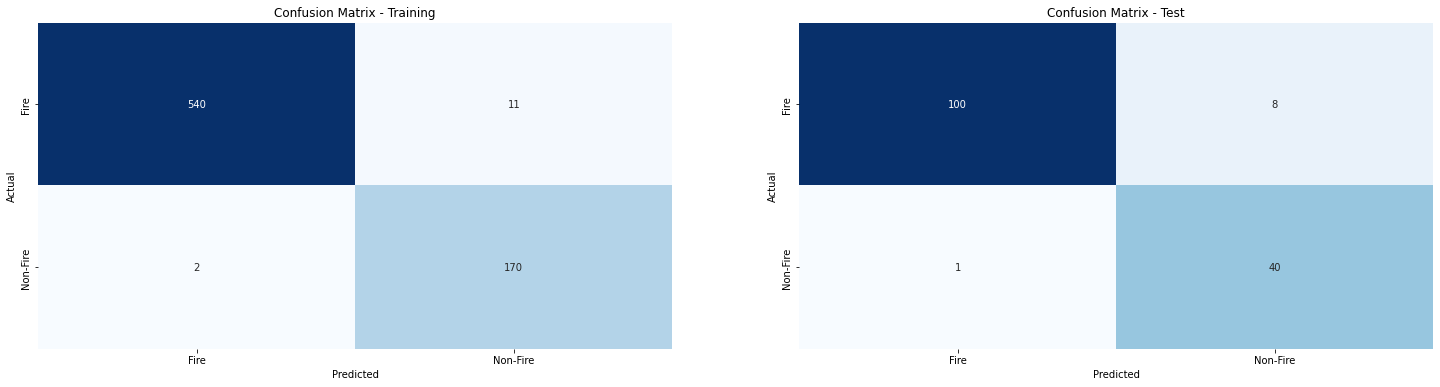

In [35]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Berdasarkan Hasil diatas, model base (model 1) yang terbentuk cukup baik dalam memprediksi gambar fire dan non fire, dibuktikan dengan confusion matriks yang ditunjukan dengan false negative dan false positif yang rendah. selain itu model ini juga memiliki nilai recall yang cukup tinggi yaitu 0.9756 , hanya saja pada model ini, model yang terbentuk sedikit overfit dan juga membutuhkan waktu komputasi yang lebih lama yaitu membutuhkan 25 epoch. berdasarkan beberapa kekurangan tersebut maka akan dicoba improvisasi terhadap model selanjutnya, yaitu menggunakan parameter tambahan seperti early stopping, model checkpoint dan juga penggunaan dropout, harus tersebut dilakukan untuk efisiensi waktu komputasi dan juga peningkatan model performansi.

Model Perfomansi pada model base ini sangat baik dimana model memiliki nilai loss yang rendah dan akurasi yang tinggi didukung dengan nilai recall dan presisi yang tinggi juga, hal tersebut membuktikan bahwa model tersebut sudah sangat baik dalam memprediksi, kekurangan pada model ini adalah model cenderung kurang stabil pada performansinya serta waktu komputasi yang cukup lama.

## **B. Model Improvement**

Setelah mendapatkan model dengan performansi pada model base,  maka tahapan selanjutnya adalah mengimprove model tersebut sehingga dapat menghasilkan perfomansi yang lebih baik lagi, salah satu cara yang akan digunakan menggunakan early stopping, untuk mencegah overfitting model, dan juga penggunaan learning rate

In [39]:
tf.keras.backend.clear_session()

In [40]:
model_imp = Sequential()
#input layer- Convolution layer with max pooling layer
model_imp.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu',input_shape = (256,256,3)))
model_imp.add(MaxPooling2D())
model_imp.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model_imp.add(MaxPooling2D())
model_imp.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model_imp.add(MaxPooling2D())

#flatten layer
model_imp.add(Flatten())
# Fully connected layer
model_imp.add(Dense(64,activation='relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.2))
model_imp.add(Dense(32,activation = 'relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.2))
model_imp.add(keras.layers.BatchNormalization())
# Output layer
model_imp.add(Dense(1,activation = 'sigmoid'))
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [41]:
model_imp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [42]:
keras.backend.clear_session()
checkpoint_path = '/content/fire_dataset'
callback_param = [tf.keras.callbacks.EarlyStopping(monitor='recall',mode = 'max', patience=5,restore_best_weights=True),
                  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='recall', mode='max', save_best_only=True)]

#train model
history1= model_imp.fit(train_data,epochs=25,batch_size=32, validation_data=valid_data, verbose =0, callbacks = callback_param)

pada model Untuk model improve ini terdapat 2 lapisan yang ditambahkan. yaitu 1 pada Convolution layer dan 1 terdapat pada connected layer. pada model ini juga ditambahkan Dropout dengan rate 0,2, penggunaan drop out juga merupakan salah satu dalam mengatasi model yang overfit, dan pada case ini akan digunakan nilai standar yaitu 0.2

Batch Normalization juga ditambahkan pada model ini dimana pada model sebelumnya cenderung memiliki gradient vanishing dan dapat dicegah dengan menggunakan batchnormalization. 

Call backs juga ditambahkan pada model ini, serta terdapat early stopping yang digunakan untuk menghentikan proses train jika model nilai recall pada model tidak terdapat peningkatan pada 5 epoch berikutnya. dan untuk menyimpan model dengan performansi terbaik maka dapat menggunakan model checkpoint. epoch pada tahapan ini menggunakan nilai awal 25, namun saat dijalankan hanya memerlukan 7 epoch untuk menghasilkan model yang cukup optimal. sehingga waktu komputasi jauh lebih cepat dibandingkan model sebelumnya


In [43]:
#melihat model summary
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

(0.5, 1.0)

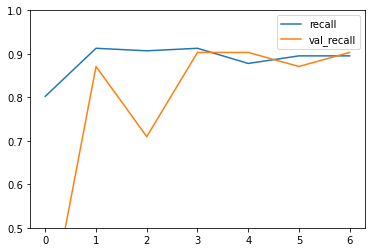

In [44]:
#recall graph
metrics = pd.DataFrame(history1.history)
metrics[["recall","val_recall"]].plot();
plt.gca().set_ylim(0.5, 1)

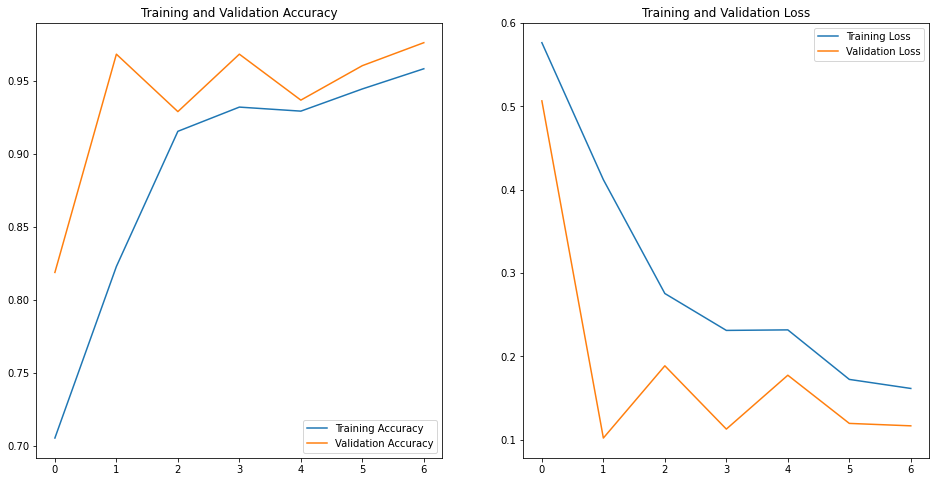

In [45]:
epochs=7 # nilai epoch 7 menyesuaikan pada run pada model improvement, yang hanya menggunakan 7 epoch
acc_imp = history1.history['accuracy']
loss_imp = history1.history['loss']

val_acc_imp = history1.history['val_accuracy']
val_loss_imp = history1.history['val_loss']
epoch_range = range(epochs)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc_imp, label='Training Accuracy')
plt.plot(epoch_range, val_acc_imp, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss_imp, label='Training Loss')
plt.plot(epoch_range, val_loss_imp, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
#print model evaluation
model_imp.evaluate(test_data)

5/5 [==============================] - 4s 564ms/step - loss: 0.1930 - accuracy: 0.9329 - recall: 0.9512 - auc: 0.9829


[0.19304202497005463,
 0.9328858852386475,
 0.9512194991111755,
 0.9829493761062622]

In [47]:
#print model evaluation
model_imp.evaluate(train_data)

23/23 [==============================] - 28s 1s/step - loss: 0.1332 - accuracy: 0.9530 - recall: 0.9012 - auc: 0.9886


[0.13315212726593018,
 0.9529737234115601,
 0.9011628031730652,
 0.9886464476585388]

In [48]:
print('-----------Training Results-----------')
train_results_imp = model_imp.evaluate(train_data_augmented_nonshuffled, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Test Results-----------')
test_results_imp = model_imp.evaluate(test_data, verbose=0)
print(f'test Loss     : {test_results[0]:.4f}')
print(f'test Accuracy : {test_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.0419
Training Accuracy   : 0.9848
-----------Test Results-----------
test Loss     : 0.1618
test Accuracy : 0.9396


In [49]:
y_pred_train_imp = tf.round(model_imp.predict(train_data_augmented_nonshuffled))
y_pred_test_imp= tf.round(model_imp.predict(test_data))
y_train_imp = train_data_augmented_nonshuffled.classes
y_test_imp = test_data.classes

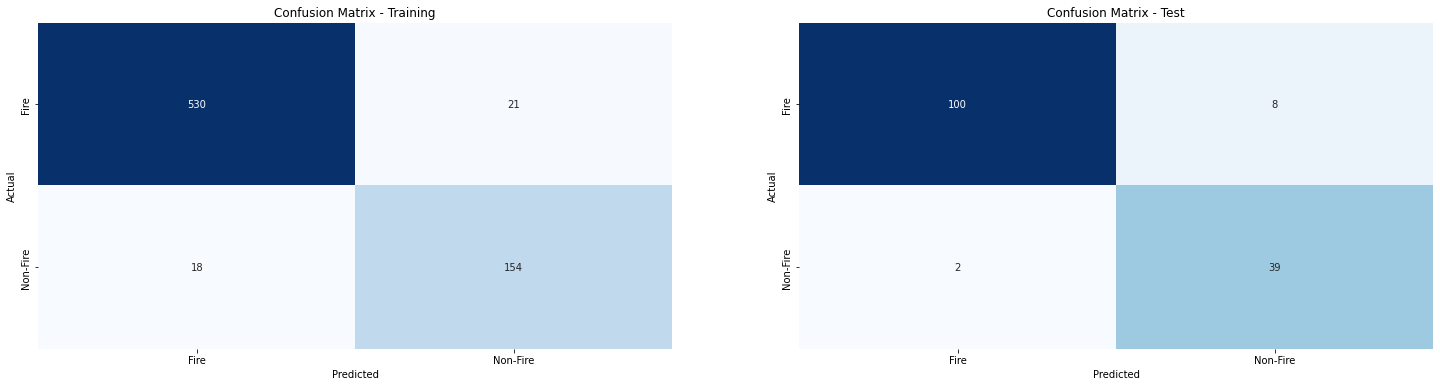

In [50]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train_imp, y_pred_train_imp), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test_imp, y_pred_test_imp), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Insight Berdasarkan Classification Report dan Confusions Matrix**

Berdasarkan hasil pada confusion matrik diatas, menunjukan bahwa model Improve 1 memiliki nilai recall yang lebih tinggi dan model yang goodfit, serta memiliki waktu komputasi yang jauh lebih cepat, pada model improve juga model dapat memprediksi keseluruhan gambar non fire, dimana pada dataset ini gambar non fire dan fire imbalanced, sehingga penekanan modelnya diharapkan dapat memprediksi dengan baik pada target data yang imbalanced, bukan hanya berpatokan pada akurasi. sehingga diharapkan, nantinya model dapat memprediksi dengan baik antara gambar non fire dan fire. berdasarkan hasil tersebut maka model Improve dipilih dan disimpan untuk kemudian dicoba diuji kembali menggunakan data inference.

**Evaluasi Terhadap Model dan Interpretasi terhadap data**

Dari hasil evaluasi pada model diatas dapat diketahui `model base` sudah dapat dengan baik memprediksi antara gambar fire dan non fire, namun model tersebut memiliki kekurangan pada waktu komputasi yang lama dan juga model yang cenderung overfit, oleh karena itu model tersebut dicoba untuk diimprove yaitu menggunakan parameter tambahan seperti callbacks, learning rate, dan juga penambahan layer dan menggunakan dropout. dan hasilnya pada model improvement, model yang terbentuk lebih baik dalam hal komputasi dan juga model yang goodfit, serta pada model improve, model dengan sempurna dapat memprediksi keseluruhan gambar yang non fire, dimana pada dataset ini, gambar non fire merupakan target yang imbalanced.

adapun setting parameter pada model tersebut adalah `Model 2 Dense/Fully Connected layer dengan jumlah neuron 64 dan 32, 3 Convolution layer dengan filters bernilai 128,68 dan 32. menggunakan activation function relu dan 1 output layer menggunakan activation sigmoid, menggunakan setting Drop_out dengan nilai 0,2 dan Batch Normalization dan setting learning rate 0.001, pada model ini juga menggunakan early stop dan model checkpoint`, pemilihan model tersebut didasarkan oleh nilai Recall dan ROC-AUC dan waktu komputasi.

Berdasarkan hasil skoring dan pengujian model didapatkan bahwa, `model yang terbentuk baik berdasarkan paramater default ataupun dengan tweak model/improvement model`, kedua model tersebut `sudah cukup baik dalam melakukan prediksi` terhadap `gambar fire ataupun non fire`, berdasarkan nilai yang dihasilkan didapatkan bahwa model `yang terbentuk good fit`, dimana `nilai` pada `training score dan test score tidak berbeda jauh`, sehingga model dapat dikategorikan goodfit, selain itu model tersebut memiliki nilai Recall yang tergolong tinggi yaitu berada direntang 0,95. 

Dalam pembentukan model ini saya ingin melihat model yang dapat memprediksi gambar fire dan non fire secara akurat , dan lebih menekankan pada prediksi non fire dengan tepat, oleh karena itu `metrik` yang perlu diperhatikan adalah `metrik roc auc dan recall`. alasan menggunakan metrik tersebut adalah, **target pada dataset ini imbalanced**.

**Kekurangan dan Kelebihan Model**

Kekurangan yang terdapat pada model ini adalah nilai akurasi skornya masih belum optimal dan dapat ditingkatkan agar mendapatkan model dengan akurasi yang tinggi, namun tidak optimalnya nilai akurasi tersebut juga dikarenakan pada model ini, data pada feature targetnya imbalanced, sehingga disarankan untuk membalancedkan rows pada feature target tersebut, agar mendapatkan nilai yang optimal.

Kelebihan model ini adalah model sudah dapat memprediksi atau mengklasifikasikan target dengan cukup akurat dan balanced terhadap kedua jenis klasifikasi target, ditunjukan dengan nilai Akurasi, ROC-AUC dan recall yang cukup tinggi diatas >90% dan juga tidak terdapat perbedaan selisih nilai yang signifikan pada skor train dan test set tersebut sehingga model yang terbentuk dapat dikatakan goodfit. model ini juga memiliki waktu komputasi yang cenderung cepat, jika dibandingkan dengan model lainnya

**Further Improvement**

Saran untuk peningkatan model ini adalah, dapat menggunakan  menggunakan transfer learning dengan model yang lain, yaitu dapat menggunakan InceptionV3 Ataupun model Xception, dimana saya mendapatkan bahwa penggunaan transfer learning tersebut dapat meningkatkan performansi dan juga mempercepat dalam tahapan training. selain itu, pada dataset ini juga dapat ditambahkan terkait gambar non fire yang memiliki warna gelap ataupun cenderung kewarna ungu, hitam ataupun putih, agar model lebih dapat memprediksi dengan baik antara gambar non fire dan fire, dimana pada model yang terbentuk ini saya mendapatkan bahwa, model terdapat miss pada saat kita mengupload data gambar yang memiliki warna cenderung gelap ataupun terang berwarna ungu, dimana model tidak bisa memprediksi jenis gambar tersebut atau termasuk kedalam kategori unpredicted atau error atau bahkan model tersebut terprediksi menjadi gambar yang memiliki unsur fire/api. penambahan dataset tersebut juga dapat memperbaiki data imbalanced pada dataset ini, sehingga diharapkan model yang terbentuk jauh lebih baik performansinya.

# **IX. *Model Saving***

Pada bagian ini model yang sudah dilakukan peningkatan akan disimpan sebagai `model` . Pada Tahapan ini sengaja dibuat menjadi comment dikarenakan model sudah disimpan dan juga agar model yang tersimpan tidak berubah ubah.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # #freeze model
# model_imp.trainable = False

In [ ]:
#memastikan bahwa model tidak trainable
#model_imp.summary()

In [ ]:
# #save model
# model_imp.save("fire_detection")

In [ ]:
# ! zip -r fire_detection.zip fire_detection

# **X. *Model Inference***

Pada bagian ini  model yang sudah terbentuk akan diuji performansinya melalui prediksi terhadap data inference. hal tersebut dilakukan untuk menunjukan bahwa model yang terbentuk dapat memprediksi dengan baik terhadap data real world/inputan data baru, sehingga dapat memastikan bahwa model yang terbentuk bukan menghafal data train melainkan benar benar memprediksi melalui pola yang terbentuk

In [53]:
url = [
       "https://dlh.bulelengkab.go.id/public/uploads/konten/kenali-hutan-dan-fungsinya-76.jpg",
       'https://img.lovepik.com/photo/20211130/medium/lovepik-thai-white-temple-tourist-scenery-picture_501249951.jpg',
       'http://assets.kompasiana.com/items/album/2020/06/24/img-20200624-124546-5ef2eb89d541df4fde4a5b62.jpg',
       'https://st4.depositphotos.com/12985848/19849/i/450/depositphotos_198498284-stock-photo-abstract-pink-purple-smoke-black.jpg',
       'https://akcdn.detik.net.id/visual/2021/07/19/ilustrasi-kebakaran_169.jpeg',
       'https://images.livemint.com/img/2021/07/30/1600x900/51719351b54642eb9c01296c8d8a3f60-51719351b54642eb9c01296c8d8a3f60-0_1627644472436_1627644512422.jpg',
       'https://imgx.parapuan.co/crop/0x0:0x0/x/photo/2022/03/27/lima-langkah-melestarikan-hutan-20220327125110.jpg',
       'https://www.jababekamorotai.com/wp-content/uploads/2019/12/air-terjun11.jpg',
       'https://www.goodnewsfromindonesia.id/uploads/post/large-shutterstock-1823026493-ae73c8dc8c09735788b6e0740a115cbe.jpg'
       ]

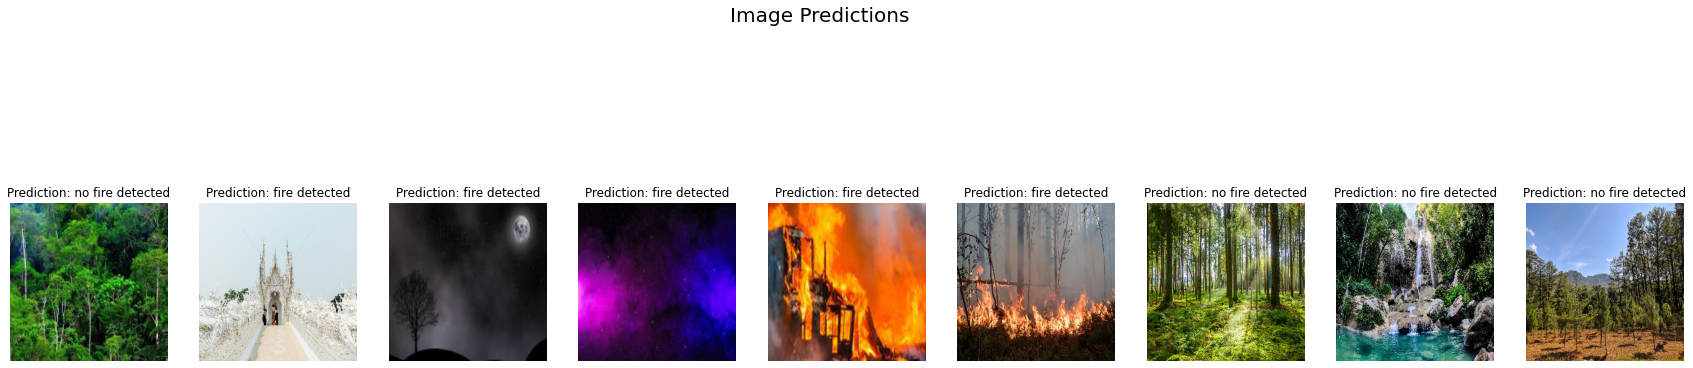

In [55]:
plt.figure(figsize=(30, 8))
plt.suptitle('Image Predictions', fontsize=20)
for i in range(len(url)):
    response = requests.get(url[i])
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    img = resize(img, size=[256, 256])
    img = img/255.
    plt.subplot(1, len(url), i+1)
    plt.imshow(img)
    res = int(tf.round(model_imp.predict(x=expand_dims(img, axis=0))))
    plt.title(f"Prediction: {'fire detected' if res == 0 else 'no fire detected'}")
    plt.axis('off')
plt.show()

# **XI.Kesimpulan**

Pada Tahapan ini kita akan mengambil kesimpulan terkait model yang sudah kita buat dan sudah diuji , serta apa saja insight yang terdapat pada dataset tersebut.

Kesimpulan yang dapat ditarik dari hasil EDA dan pemodelan menggunakan CNN ini adalah:

Dataset yang digunakan akan adalah dataset yang berisi gambar kebakaran dan juga api yang berjumlah **999 gambar** dimana setiap gambarnya memiliki ukuran pixel yang berbeda-beda, mulai dari gambar berresolusi rendah hingga gambar beresolusi tinggi. Dari hasil EDA, gambar-gambar yang berlabel **fire** cenderung lebih gelap dan didominasi oleh warna **merah** dan **orange**, sedangkan untuk gambar-gambar yang berlabel **non_fire** cenderung lebih terang dan didominasi oleh warna **hijau** dan **biru**.

dikarenakan terdapat perbedaan ukuran/dimensi pada dataset ini maka perlu dilakukan beberapa tahapan sebelum membuat model prediksi diantaranya adalah
menyamakan ukuran dari setiap gambarnya yaitu menjadi **256x256 pixel**. pada case ini dibentuk 2 model yaitu model pertama merupakan model base tanpa menggunakan parameter improvement seperti early stop, model checkpoint, dropout, learning rate dan batch normalization. dimana pada model pertama model yang terbentuk sudah sangat baik dalam memprediksi, dibuktikan dengan nilai akurasi dan roc-auc, recall dan presisi yang tinggi, serta false negatif dan false positif yang rendah. namun kekurangan pada model pertama ini adalah waktu komputasi yang cukup lama dan model cenderung overfit. oleh karena itu diperlukan improvisasi terhadap model tersebut, yaitu dengan menambahkan beberapa parameter untuk mempercepat model seperti callback, earlstopping, model checkpoint serta penggunaan learning rate dan drop out untuk membuat model tidak overfit, dan hasilnya model yang terbentuk lebih baik dibandingkan model sebelumnya. 

Kekurangan yang terdapat pada model ini adalah nilai akurasi skornya masih belum optimal dan dapat ditingkatkan agar mendapatkan model dengan akurasi yang tinggi, namun tidak optimalnya nilai akurasi tersebut juga dikarenakan pada model ini, data pada feature targetnya imbalanced, sehingga disarankan untuk membalancedkan rows pada feature target tersebut, agar mendapatkan nilai yang optimal.

Kelebihan model ini adalah model sudah dapat memprediksi atau mengklasifikasikan target dengan cukup akurat dan balanced terhadap kedua jenis klasifikasi target, ditunjukan dengan nilai Akurasi, ROC-AUC dan recall yang cukup tinggi diatas >90% dan juga tidak terdapat perbedaan selisih nilai yang signifikan pada skor train dan test set tersebut sehingga model yang terbentuk dapat dikatakan goodfit. model ini juga memiliki waktu komputasi yang cenderung cepat, jika dibandingkan dengan model lainnya

**hal menarik yang dapat dilihat pada case ini adalah, model kurang cukup baik dalam memprediksi gambar yang berwarna cerah ataupun gelap, seperti contoh kasus yang ditampilkan pada model inference, dimana model salah menebak gambar tersebut, hal tersebut dapat dikarenakan, terbatasnya jenis warna gambar didataset train, yang terbatas hanya pada gambar berwarna hijau, orange dan merah, sedangkan warna lain seperti putih, hitam dll, cenderung sangat sedikit, sehingga model cukup bias terhadap gambar yang memiliki warna tersebut**. oleh karena itu perlu adanya beberapa improvement pada dataset ini yaitu dapat ditambahkan terkait gambar non fire yang memiliki warna gelap ataupun cenderung kewarna ungu, hitam ataupun putih, agar model lebih dapat memprediksi dengan baik antara gambar non fire dan fire, dimana pada model yang terbentuk ini saya mendapatkan bahwa, model terdapat miss pada saat kita mengupload data gambar yang memiliki warna cenderung gelap ataupun terang berwarna ungu, dimana model tidak bisa memprediksi jenis gambar tersebut atau termasuk kedalam kategori unpredicted atau error atau bahkan model tersebut terprediksi menjadi gambar yang memiliki unsur fire/api. penambahan dataset tersebut juga dapat memperbaiki data imbalanced pada dataset ini, sehingga diharapkan model yang terbentuk jauh lebih baik performansinya.
